## Individual Recommender system
Running the cell below you can actually put the individual recommender system in practice. Do not add any actual code about the recommenders in this notebook, do that in 'recommender.ipynb' and then import the necessary methods you need. (ask chatgpt how to do so) 

In [77]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import random



In [78]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
import csv
import keyboard
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsRegressor

In [79]:
ratings_df = pd.read_csv('Data/filtered_ratings.csv')
movies = pd.read_csv('Data/movies.csv')
genome_scores_df = pd.read_csv('Data/filtered_genome_scores.csv')
genome_tags_df = pd.read_csv('Data/genome_tags.csv')

In [134]:
def get_movie_name(movie_id):
    movie_row = movies[movies['movieId'] == movie_id]

    if not movie_row.empty:
        return movie_row['title'].iloc[0]
    else:
        return "Movie not in the list"
        
def get_movie_id(movie_name):
    movie_row = movies[movies['title'] == movie_name]

    if not movie_row.empty:
        return movie_row['movieId'].iloc[0]
    else:
        return "Movie not found in the list"


In [54]:
def newUser(movie_ratings):
    new_user_id = 1
    
    # Find the next available user ID
    with open('Data/filtered_ratings.csv', mode='r', newline='') as file:
        csv_reader = csv.reader(file)
        next(csv_reader)  # Skip the header row
        existing_user_ids = set()
        for row in csv_reader:
            existing_user_ids.add(int(row[0]))
        while new_user_id in existing_user_ids:
            new_user_id += 1

    # Write the new user's ratings to the CSV file, each in a separate row
    with open('Data/filtered_ratings.csv', mode='a', newline='') as file:
        writer = csv.writer(file)
        for movie_id, rating in movie_ratings.items():
            writer.writerow([new_user_id, movie_id, rating])
    return new_user_id

In [208]:
import difflib

def getMovieTags(movie_id, genome_scores_df, genome_tags_df):
    movie_scores = genome_scores_df[genome_scores_df['movieId'] == movie_id]
    
    movie_tags = movie_scores.merge(genome_tags_df, on='tagId', how='left')
    
    tag_relevance_dict = {}
    for row in movie_tags.itertuples(index=False):
        tag_name = row.tag
        relevance = row.relevance
        tag_relevance_dict[tag_name] = relevance
    
    return tag_relevance_dict

def getUserTags(user_id, ratings_df, genome_scores_df, genome_tags_df):
    # Filter ratings_df for movies rated by the user
    user_movies = ratings_df[ratings_df['userId'] == user_id]

    # Create a nested dictionary to store movie names, tags, and their relevance
    user_tags_dict = {}

    # Iterate through movies rated by the user
    for _, row in user_movies.iterrows():
        movie_id = row['movieId']
        movie_name = get_movie_name(movie_id) # Get movie name
        user_tags_dict[movie_name] = {}  # Create a dictionary for the movie

        # Filter genome_scores_df for the current movie
        movie_scores = genome_scores_df[genome_scores_df['movieId'] == movie_id]

        # Merge the filtered dataframe with genome_tags_df to get tag names
        movie_tags = movie_scores.merge(genome_tags_df, on='tagId', how='left')

        for _, tag_row in movie_tags.iterrows():
            tag_name = tag_row['tag']
            relevance = tag_row['relevance']
            user_tags_dict[movie_name][tag_name] = relevance

    return user_tags_dict
    
def getIntersectedTags(user_tags, movie_tags):
    intersected_tags = {}  # Dictionary to store intersected tags and their absolute relevance difference

    # Iterate through movies in the user's tag relevance dictionary
    for movie, user_movie_tags in user_tags.items():
        for tag, user_relevance in user_movie_tags.items():
            if tag in movie_tags:
                movie_relevance = movie_tags[tag]
                difference = 1 - abs(user_relevance - movie_relevance)
                intersected_tags[tag] = difference

    return intersected_tags


def getMoviesWithTag(tag, user_tags_dict):
    movies_with_tag = []

    # Iterate through each movie in the user_tags_dict
    for movie, tags in user_tags_dict.items():
        # Check if the given tag is present in the movie's tags
        if tag in tags:
            movies_with_tag.append(movie)

    return movies_with_tag

def getExplanations(intersected_tags, user_tags, movie_tags, user_ratings):
    explanations = []

    sentence_printed = False
    explanation = "You might like this movie because it contained the tags"

    tags_processed = 0
    if len(intersected_tags) == 0:
        return 0
        
    for tag, similarity in intersected_tags.items():
        if similarity > 0.5 and tags_processed < 3:  # Limit to the first 3 tags
            if not sentence_printed:
                sentence_printed = True
            else:
                explanation += ","

            movies_with_tag = getMoviesWithTag(tag, user_tags)

            liked_movies_with_tag = [movie for movie in movies_with_tag if user_ratings.get(get_movie_id(movie), 0) > 3.5][:3]

            if liked_movies_with_tag:
                liked_movie_names = [get_movie_name(get_movie_id(movie)) for movie in liked_movies_with_tag]
                explanation += f" '{tag}'"
                tags_processed += 1

    liked_movie_names = [get_movie_name(get_movie_id(movie)) for movie in liked_movies_with_tag]
    explanation += f" which also appear in movies you rated higher than 3.5 like {', '.join(liked_movie_names)}."

    explanations.append(explanation)

    return explanations



def predict_ratings_tags(user_id, movie_id, ratings_df, genome_scores_df, genome_tags_df):

    user_tags = getUserTags(user_id, ratings_df, genome_scores_df, genome_tags_df)
    movie_tags = getMovieTags(1, genome_scores_df, genome_tags_df)

    intersected_tags = getIntersectedTags(user_tags, movie_tags)

    if not intersected_tags:
        return 0.0

    size_ratio = len(intersected_tags) / len(movie_tags)

    total_similarity = (sum(intersected_tags.values()) / len(intersected_tags)) * size_ratio
    mapped_similarity = 0.5 + total_similarity * 4.5

    return mapped_similarity




In [185]:
def get_user_ratings(user_id, ratings_df):
    user_ratings_df = ratings_df[ratings_df['userId'] == user_id]
    
    user_ratings = {}
    
    for index, row in user_ratings_df.iterrows():
        movie_id = row['movieId']
        rating = row['rating']
        user_ratings[movie_id] = rating
    
    return user_ratings

max_user_id = 610

In [209]:
user_id_ex = 1
movie_id_ex = 1
user_tags = getUserTags(user_id_ex, ratings_df, genome_scores_df, genome_tags_df)
movie_tags_ex = getMovieTags(1, genome_scores_df, genome_tags_df)
user_ratings_ex = get_user_ratings(user_id_ex, ratings_df)
intersected_tags = getIntersectedTags(user_tags, movie_tags_ex)
print(getExplanations(intersected_tags,user_tags, movie_tags_ex, user_ratings_ex))

["You might like this movie because it contained the tags 'adventure', 'children', 'kids' which also appear in movies you rated higher than 3.5 like E.T. the Extra-Terrestrial (1982), Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981), Stand by Me (1986)."]


In [228]:
def recommendKNN(movie_ratings, new_user_id, ratings_df):
    selected_user = new_user_id 
    selected_user_ratings = ratings_df.loc[ratings_df['userId'] == new_user_id]
    selected_user_ratings['item'] = selected_user_ratings.index
    
    selected_user_ratings = selected_user_ratings.sort_values(by='item', ascending=True)
    selected_movie_ids = set(selected_user_ratings['movieId'])
    
    rated_movies_df = movies.reindex(list(selected_user_ratings['movieId']))
# rated_movies_df = movies_df[movies_df['movieId'].isin(selected_movie_ids)]
    rated_movies_df = rated_movies_df[['title', 'genres']]
    rated_movies_df['item'] = rated_movies_df.index 
    
    diff = set(movies.index) - set(rated_movies_df.index)
    unrated_movies_df = movies.loc[diff]
    unrated_movies_df = unrated_movies_df[['title', 'genres', 'movieId']]
    
    rated_movies_df = rated_movies_df.join(selected_user_ratings.set_index('movieId')['rating'], on='item')
    rated_movies_df['genres'].fillna('', inplace=True)
    
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(rated_movies_df['genres'])
    rated_movies_df['genres'].fillna('', inplace=True)
    
    y = rated_movies_df['rating']
    
    neighbors = 0
    if len(movie_ratings) < 5:
        neighbors = len(movie_ratings)
    else:
        neighbors = 5
    
    neigh = KNeighborsRegressor(n_neighbors=neighbors)
    neigh.fit(X, y)
    
    X_unrated = vectorizer.transform(unrated_movies_df['genres'])
    y_unrated = neigh.predict(X_unrated)
    unrated_movies_df['predicted_ratings_KNN'] = y_unrated
    unrated_movies_df_KNN_ordering = unrated_movies_df.sort_values(by='predicted_ratings_KNN', ascending=False)
    top_10_movies = unrated_movies_df_KNN_ordering.head(10)

    user_tags = getUserTags(new_user_id, ratings_df, genome_scores_df, genome_tags_df)
    
    for i, (index, movie) in enumerate(top_10_movies.iterrows(), 1):
        print(f"{i}) Movie: {movie['title']}, Genre: {movie['genres']}")
        movie_tags = getMovieTags(movie['movieId'], genome_scores_df, genome_tags_df)
        intersected_tags = getIntersectedTags(user_tags, movie_tags)

        explanations = getExplanations(intersected_tags, user_tags, movie_tags, movie_ratings)
        if explanations != 0:
            for explanation in explanations:
                print(explanation)


In [221]:
user_id = 7
movie_ratings = get_user_ratings(user_id, ratings_df)
recommendKNN(movie_ratings, user_id, ratings_df)

C:\Users\Alvaro\AppData\Local\Temp\ipykernel_8744\2498579319.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_user_ratings['item'] = selected_user_ratings.index
C:\Users\Alvaro\AppData\Local\Temp\ipykernel_8744\2498579319.py:15: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  unrated_movies_df = movies.loc[diff]


1) Movie: House by the River (1950), Genre: Crime|Drama|Film-Noir
2) Movie: Kiss of Death (1947), Genre: Crime|Drama|Film-Noir
You might like this movie because it contained the tags 'original', 'drama', 'mob' which also appear in movies you rated higher than 3.5 like Bullets Over Broadway (1994).
3) Movie: Brasher Doubloon, The (1947), Genre: Crime|Drama|Film-Noir|Mystery
4) Movie: Kansas City Confidential (1952), Genre: Crime|Drama|Film-Noir|Mystery
5) Movie: I Declare War (2012), Genre: Action|Comedy|Drama
6) Movie: Driver, The (1978), Genre: Action|Crime|Film-Noir
7) Movie: Killer Is Loose, The (1956), Genre: Crime|Drama|Film-Noir
8) Movie: Paid (1930), Genre: Crime|Drama|Film-Noir
9) Movie: Desperate Hours, The (1955), Genre: Drama|Film-Noir|Thriller
You might like this movie because it contained the tags 'original', 'drama', 'gangster' which also appear in movies you rated higher than 3.5 like Bullets Over Broadway (1994).
10) Movie: Where Danger Lives (1950), Genre: Drama|Film-N

In [16]:
def deleteRows():
    input_file = "Data/filtered_ratings.csv"

# Read the CSV file into a pandas DataFrame
    df = pd.read_csv(input_file)
    # Find the index of the first row where userId is greater than or equal to 100000
    start_index = df[df['userId'] > 10000].index[0]

    # Keep only the rows up to the start_index
    df = df.iloc[:start_index]

    # Save the updated DataFrame back to the original file, overwriting it
    df.to_csv(input_file, index=False)
    

In [272]:
def compute_similarity(genre_rating, contains_genre):
    return 2.75 if not contains_genre else genre_rating

def getMovieGenres(movie_id):
    movie_row = movies[movies['movieId'] == movie_id]

    if not movie_row.empty:
        genres_str = movie_row['genres'].iloc[0]
        
        genres_list = genres_str.split('|')
        
        return genres_list
    else:
        return []
        
def getGenresDict(genres, movie_id):
    movieGenres = getMovieGenres(movie_id)
    genresDict = {}
    for genre, rating in genres.items():  # Iterate through the genres dictionary with keys and values
        if genre in movieGenres:
            genresDict[genre] = True
        else:
            genresDict[genre] = False
    return genresDict


def recommendMovie(user_ratings, movies_df, ratings_df, n):
    movie_ratings_count = ratings_df['movieId'].value_counts().reset_index()
    movie_ratings_count.columns = ['movieId', 'count']
    popular_movies = movies_df.merge(movie_ratings_count, on='movieId', how='inner')
    popular_movies = popular_movies[popular_movies['count'] > 3]
    popular_movies = popular_movies.sort_values(by='count', ascending=False)

    recommended_movies = []
    for movie_id in popular_movies['movieId']:
        if len(recommended_movies) >= n:
            break
        if movie_id not in user_ratings:
            # Use predictRating method to predict the rating
            predicted_rating = predictRating(user_ratings, movie_id)
            if predicted_rating > 3:
                recommended_movies.append(movie_id)
    recommendations_str = ""
    for id in recommended_movies:
        recommendations_str += get_movie_name(id) + "\n"

    return recommendations_str

def getGenreRatings(user_ratings):
    genres = {}
    genre_counts = {}  
    for movie_id, rating in user_ratings.items():
        movie_genres = getMovieGenres(movie_id)
        for current_genre in movie_genres:
            genres[current_genre] = genres.get(current_genre, 0) + rating
            genre_counts[current_genre] = genre_counts.get(current_genre, 0) + 1

    for genre in genres:
        genres[genre] /= genre_counts[genre]  # Divide the total rating by the number of times the genre appears

    return genres

    
getGenreRatings({1: 5.0, 3: 2.5})

def predictRating(user_ratings, movie_to_predict_id):
    weighted_sum = 0.0
    ratings = getGenreRatings(user_ratings)
    contains_genres = getGenresDict(ratings, movie_to_predict_id)

    for movie_id in ratings:
        similarity = compute_similarity(ratings[movie_id], contains_genres[movie_id]) / len(ratings)
        weighted_sum += similarity

    return weighted_sum


def getAllGenres(movies_df):
    genres_column = movies_df['genres']
    genre_lists = [genres.split('|') for genres in genres_column]
    flat_genre_list = [genre for sublist in genre_lists for genre in sublist]
    unique_genres = set(flat_genre_list)
    return list(unique_genres)

all_genres = getAllGenres(movies)



In [218]:
movie_ratings = {}
while True:
    movie_name = input("Enter a movie name (or 'done' to finish): ")
    
    if movie_name.lower() == 'done' or keyboard.is_pressed('esc'):
        break
    
    matched_movies = process.extractOne(movie_name, movies['title'], scorer=fuzz.token_set_ratio)

    if matched_movies[1] >= 80:  # Similarity threshold
        movie_id = movies[movies['title'] == matched_movies[0]]['movieId'].values[0]
        correct_movie_name = matched_movies[0]
        while True:
            rating = input(f"Enter a rating for '{correct_movie_name}' (1-5): ")
            try:
                rating = float(rating)
                if 1 <= rating <= 5:
                    break
               
                else:
                    print("Rating must be between 1 and 5.")
            except ValueError:
                print("Invalid rating. Please enter a number between 1 and 5.")
        
        movie_ratings[movie_id] = rating
        print(f"Rating for '{correct_movie_name}' added.")
    else:
        print(f"Movie '{movie_name}' not found in the database.")
    
if movie_ratings:
    while True:
        recommendation_type = input("Enter 'genre' for genre-based recommendation or 'knn' for similar user recommendation: ").lower()
        if recommendation_type == 'genre':
            print(recommendMovie(movie_ratings, movies, ratings_df, 5))
        elif recommendation_type == 'knn':

            #----------------------------ADD YOUR WORK HERE-----------------------------
            user = newUser(movie_ratings)
            ratings_df = pd.read_csv('Data/filtered_ratings.csv')
            print("Your recommendations are:")
            recommendKNN(movie_ratings,user, ratings_df)
            print("\n")
            print("\n")
            deleteRows()
#             print('ADD HERE YOUR EXPLANATION ON THE MOVIE RECOMMENDATIONS')
            #----------------------------ADD YOUR WORK HERE-----------------------------

        else:
            print("Invalid choice. Please enter 'genre' or 'user'.")
        break




Rating for 'Toy Story (1995)' added.
Rating for 'Jurassic Park (1993)' added.
Your recommendations are:


C:\Users\Alvaro\AppData\Local\Temp\ipykernel_8744\2498579319.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_user_ratings['item'] = selected_user_ratings.index
C:\Users\Alvaro\AppData\Local\Temp\ipykernel_8744\2498579319.py:15: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  unrated_movies_df = movies.loc[diff]


1) Movie: Toy Story (1995), Genre: Adventure|Animation|Children|Comedy|Fantasy
You might like this movie because it contained the tags, 'computer animation',, 'kids and family',, 'kids' which also appear in movies you rated higher than 3.5 like Jurassic Park (1993).
2) Movie: River Why, The (2010), Genre: Drama
3) Movie: From Beyond the Grave (Creatures) (1974), Genre: Horror
4) Movie: Wuthering Heights (2011), Genre: Drama
5) Movie: Wichita (1955), Genre: Action|Romance|Western
6) Movie: Story of Mankind, The (1957), Genre: Drama|Fantasy
7) Movie: Fright (1972), Genre: Crime|Horror|Thriller
8) Movie: Shaolin (Xin shao lin si) (2011), Genre: Action|Drama
9) Movie: Big Hangover, The (1950), Genre: Comedy
10) Movie: Another Happy Day (2011), Genre: Drama






NameError: name 'deleteRows' is not defined

In [254]:
user_ratings_kid = {1: 5.0, 2: 5.0, 364: 4.0, 6377: 4.0}
print(recommendMovie(user_ratings_kid, movies, ratings_df, 5))

10644
Pulp Fiction (1994)
Forrest Gump (1994)
Apollo 13 (1995)
American Beauty (1999)
Dances with Wolves (1990)



### Indivual Recimmender using KNN

In [ ]:
users_ratings = ratings_df.groupby(['userId']).count()

selected = users_ratings['rating'] > 200
selected_users = users_ratings.loc[selected]
random_selected = selected_users.sample() # sample() returns a random row from the dataframe. The returned object is a dataframe with one row. If you pass a number as argument you specify to select more than one row.
select_column_df = random_selected.reset_index()['userId'] # reset_index() create a new index, and the user became a column. Then, we can filter using the column name
selected_user = select_column_df.iloc[0] # iloc select by index, since our dataframe only has one row we read it from the index 0
# selected_user = 19
print("Selected user: " + str(selected_user))

In [ ]:
selected_user_ratings = ratings_df.loc[ratings_df['userId'] == selected_user]
selected_user_ratings['item'] = selected_user_ratings.index 
selected_user_ratings.to_csv('selected_user_ratings.csv', index=False)
selected_user_ratings = selected_user_ratings.sort_values(by='item', ascending=True)
print("Rated movies: " + str(selected_user_ratings.shape[0]))
# display(selected_user_ratings.head(10))

In [ ]:
selected_movie_ids = set(selected_user_ratings['movieId'])
rated_movies_df = movies.reindex(list(selected_user_ratings['movieId']))
# rated_movies_df = movies_df[movies_df['movieId'].isin(selected_movie_ids)]
rated_movies_df = rated_movies_df[['title', 'genres']]
rated_movies_df['item'] = rated_movies_df.index 
rated_movies_df.to_csv('rated_movies_df.csv', index=False)

In [ ]:
diff = set(movies.index) - set(rated_movies_df.index)
unrated_movies_df = movies.loc[diff]
# display(unrated_movies_df.head())
unrated_movies_df = unrated_movies_df[['title', 'genres']]
print("Unrated movies: " + str(unrated_movies_df.shape[0]))
# display(unrated_movies_df.head(10))

In [ ]:
rated_movies_df = rated_movies_df.join(selected_user_ratings.set_index('movieId')['rating'], on='item')
print("Rated movies: " + str(rated_movies_df.shape[0]))
# display(rated_movies_df.head(10))

In [ ]:
rated_movies_df['genres'].fillna('', inplace=True)
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(rated_movies_df['genres'])
rated_movies_df['genres'].fillna('', inplace=True)
y = rated_movies_df['rating']
neigh = KNeighborsRegressor(n_neighbors=5)
neigh.fit(X, y)
X_unrated = vectorizer.transform(unrated_movies_df['genres'])
y_unrated = neigh.predict(X_unrated)
unrated_movies_df['predicted_ratings_KNN'] = y_unrated


In [ ]:
user_ratings = movie_ratings  # Use the provided 'movie_ratings' dictionary

# Train a KNN model to predict ratings
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(rated_movies_df['genres'])
y = rated_movies_df['rating']

neigh = KNeighborsRegressor(n_neighbors=5)
neigh.fit(X, y)

#Predict ratings for unrated movies
X_unrated = vectorizer.transform(unrated_movies_df['genres'])
y_unrated = neigh.predict(X_unrated)

#Dictionary with movie IDs and predicted ratings
predicted_ratings = {}
for idx, movie_id in enumerate(unrated_movies_df.index):
    predicted_ratings[movie_id] = y_unrated[idx]

user_and_predicted_ratings = {**user_ratings, **predicted_ratings}

# Sort the movies based on the combined ratings
sorted_movies = sorted(user_and_predicted_ratings.items(), key=lambda x: x[1], reverse=True)

# Print the top 10 recommended movies
print("Top 10 Recommended Movies:")
for i, (movie_id, rating) in enumerate(sorted_movies[:10], 1):
    print(f"{i}. Movie ID: {movie_id}, Rating: {rating}")
for i, (movie_id, rating) in enumerate(sorted_movies[:10], 1):
    print(f"{i}. Movie : {get_movie_name(movie_id)}, Rating: {rating}")

In [ ]:
user_id_ex = 8976
movie_id_ex = 64839
predict_ratings_tags(user_id_ex, movie_id_ex, ratings_df, genome_scores_df, genome_tags_df)

In [252]:
def test_tags_based(movies_df, ratings_df):
    # Convert ratings_df to a list of records
    ratings_list = list(ratings_df.to_records(index=False))
    
    # Use random.sample on the list of records
    random_ratings = random.sample(ratings_list, 10)

    actual_ratings = []  # Actual ratings (x-axis)
    predicted_ratings = []  # Predicted ratings (y-axis)

    for record in random_ratings:
        user_id, movie_id, actual_rating = record
        predicted_rating = predict_ratings_tags(user_id, movie_id, ratings_df, genome_scores_df, genome_tags_df)

        actual_ratings.append(actual_rating)
        predicted_ratings.append(predicted_rating)

    # Plot actual vs predicted ratings
    plt.figure(figsize=(8, 6))
    plt.scatter(actual_ratings, predicted_ratings, alpha=0.5)
    plt.xlabel('Actual Ratings')
    plt.ylabel('Predicted Ratings')
    plt.title('Actual vs Predicted Ratings')
    plt.grid(True)
    plt.show()



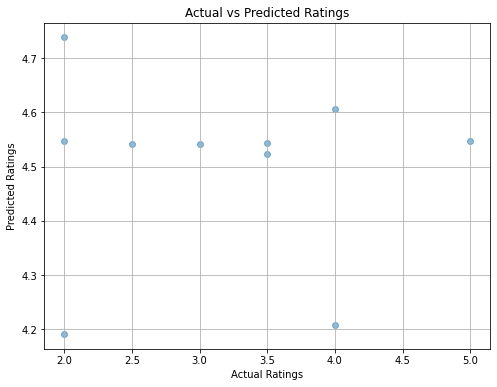

In [253]:
test_tags_based(movies, ratings_df)


## Group Recommender system
In this case I decided not to ask the users for the ratings because it is counterproductive. In this case, the group ratings will be already defined in the code


In [ ]:
#Some random group users movie ratings
group_movie_ratings = [
    {1: 5, 2: 3, 13: 4, 3: 4.5},
    {190: 2, 9372: 4, 837: 1.5},
    {89: 3.5, 7521: 3, 90: 3.5}
]

In [262]:
def mergeRatings(group_ratings):
    movie_ratings = {}  # Dictionary to store movie ratings and counts

    for user_ratings in group_ratings:
        for movie_id, rating in user_ratings.items():
            if movie_id in movie_ratings:
                movie_ratings[movie_id]['total_rating'] += rating
                movie_ratings[movie_id]['count'] += 1
            else:
                movie_ratings[movie_id] = {
                    'total_rating': rating,
                    'count': 1
                }

    average_ratings = {}  # Dictionary to store average ratings

    for movie_id, data in movie_ratings.items():
        average_ratings[movie_id] = data['total_rating'] / data['count']

    return average_ratings

    

In [275]:
group_movie_ratings = [
    {1: 5, 2: 3, 13: 4, 3: 4.5},
    {190: 2, 9372: 4, 837: 1.5},
    {89: 3.5, 7521: 3, 90: 3.5}
]
mergedRatings = mergeRatings(group_movie_ratings) #Hay que añadir las explanations todvia
print (recommendMovie(mergedRatings, movies, ratings_df, n=5))


Forrest Gump (1994)
True Lies (1994)
Aladdin (1992)
Lion King, The (1994)
Beauty and the Beast (1991)



In [259]:
user_ratings_kid = {1: 5.0, 2: 5.0, 364: 4.0, 6377: 4.0}
print(recommendMovie(user_ratings_kid, movies, ratings_df, 5))

Pulp Fiction (1994)
Forrest Gump (1994)
Apollo 13 (1995)
American Beauty (1999)
Dances with Wolves (1990)

